# Outlier detection using Isolation Forest
Created by Ivan Lima on Wed Oct 13 2021 08:59:21 -0400

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os, datetime
print('Last updated on {}'.format(datetime.datetime.now().ctime()))

Last updated on Wed Oct 13 12:40:27 2021


In [2]:
sns.set_theme(context='paper', style='whitegrid', palette='tab10', rc={'figure.dpi':100, 'figure.figsize':[5, 5]})
pd.options.display.max_columns = 50

## Read data

In [3]:
df = pd.read_csv('data/bottle_satellite_data.csv', parse_dates=['Date'], index_col=0)
df['bottom_depth'] = df.bottom_depth.abs() # convert negative to positive values

# flag anomalous O2 values
df['outlier'] = 0 # outlier flag
df.loc[df.Oxygen>500, 'outlier'] = 1
df.loc[(df.Oxygen>300) & (df.Depth>200), 'outlier'] = 1
df = df[df.outlier==0]

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2744 entries, 0 to 3039
Data columns (total 45 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   X.x                  2744 non-null   int64         
 1   X.y                  2744 non-null   int64         
 2   DOI                  2744 non-null   object        
 3   EXPOCODE             1469 non-null   object        
 4   Accession            101 non-null    float64       
 5   Cruise_ID            2025 non-null   object        
 6   Date                 2744 non-null   datetime64[ns]
 7   Year                 2744 non-null   int64         
 8   Month                2744 non-null   int64         
 9   Day                  2744 non-null   int64         
 10  Time_UTC             2664 non-null   object        
 11  Latitude             2744 non-null   float64       
 12  Longitude            2744 non-null   float64       
 13  Depth_bottom         1484 non-nul

## Detect outliers 

Here we apply Isolation Forest to the input variables: depth, temperature, salinity, dissolved oxygen, DIC and total alkalinity.

55 outliers out of data 2744 points


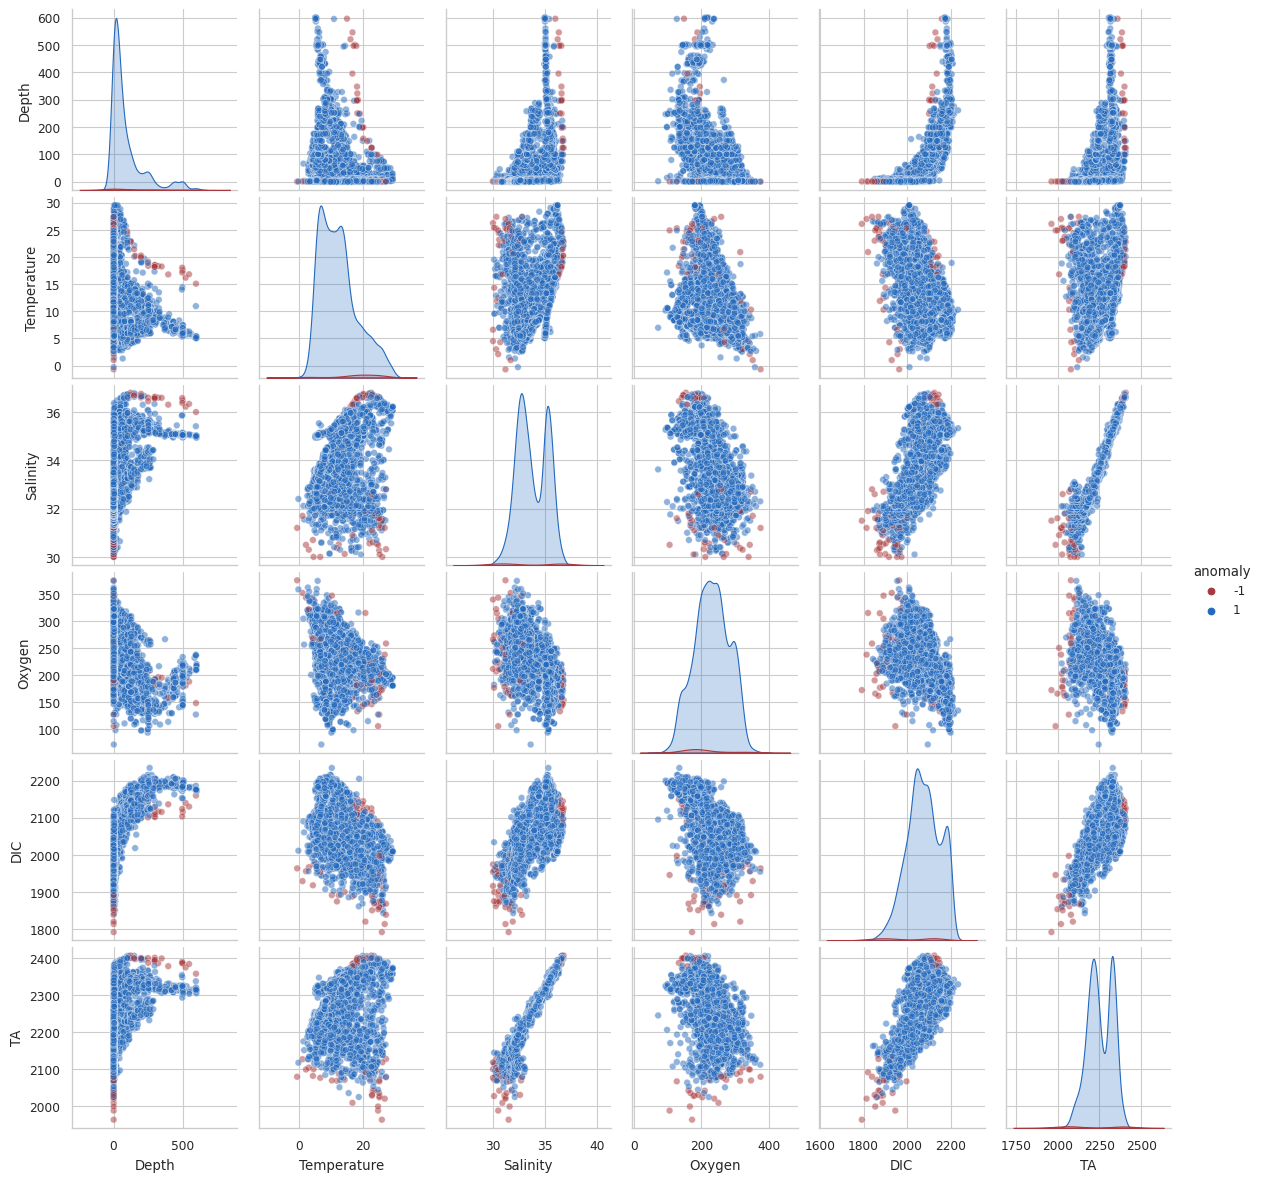

In [4]:
from sklearn.ensemble import IsolationForest, RandomForestClassifier

bot_vars = ['Depth', 'Temperature', 'Salinity', 'Oxygen', 'DIC', 'TA']

X = df[bot_vars].values
iforest = IsolationForest(n_estimators=500, random_state=42, contamination=0.02, n_jobs=-1).fit(X)
df['anom_score'] = iforest.score_samples(X)
df['anomaly'] = iforest.predict(X)

print('{} outliers out of data {} points'.format(len(df[df.anomaly==-1]), len(df)))

fg = sns.pairplot(df, vars=bot_vars, hue='anomaly', palette='vlag_r', height=2, plot_kws={'alpha':0.5})

## Feature importance

Estimate feature importance by fitting a Random Forest classifier to the Isolation Forest predictions.

Training score: 1.0000
Test score:     0.9913
Final model cross-validation mean score: 0.9792


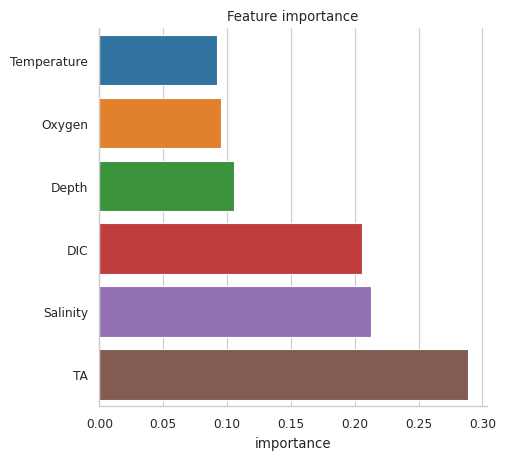

In [5]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

y = df['anomaly'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

rfr = RandomForestClassifier(random_state=42, n_estimators=500, n_jobs=-1)
rfr.fit(X_train, y_train)
scores = cross_val_score(rfr, X, y, cv=5, n_jobs=-1)

print('Training score: {:.4f}'.format(rfr.score(X_train, y_train)))
print('Test score:     {:.4f}'.format(rfr.score(X_test, y_test)))
print('Final model cross-validation mean score: {:.4f}'.format(scores.mean()))

df_rfr = pd.DataFrame(rfr.feature_importances_, index=bot_vars, columns=['importance'])
df_rfr = df_rfr.sort_values('importance')
fig, ax = plt.subplots()
_ = sns.barplot(data=df_rfr, y=df_rfr.index, x='importance', orient='horizontal', ax=ax)
_ = ax.set_title('Feature importance')
sns.despine(fig)